In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from PIL import Image, ImageFile
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision.models as models

ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:
use_cuda = torch.cuda.is_available()

In [4]:
import numpy as np
from glob import glob

dog_files = np.array(glob("/data/dog_images/*/*/*"))

# train, test and validation files of dog datset

dog_train = np.array(glob("/data/dog_images/train/*/*"))
dog_valid = np.array(glob("/data/dog_images/valid/*/*"))
dog_test = np.array(glob("/data/dog_images/test/*/*"))

In [5]:
# print number of images in each dataset
print('There are %d total dog images.' % len(dog_files))
print('There are %d total train dog images.' % len(dog_train))
print('There are %d total validation dog images.' % len(dog_valid))
print('There are %d total test dog images.' % len(dog_test))

There are 8351 total dog images.
There are 6680 total train dog images.
There are 835 total validation dog images.
There are 836 total test dog images.


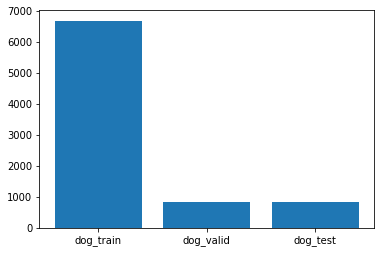

In [6]:
import matplotlib.pyplot as plt

bars = ('dog_train', 'dog_valid', 'dog_test')
height = [len(dog_train), len(dog_valid), len(dog_test)]
y_pos = np.arange(len(bars))


plt.bar(y_pos, height)
plt.xticks(y_pos, bars)

plt.show()

In [7]:
dog_names = [item[27:-1] for item in sorted(glob("/data/dog_images/train/*"))]
Dog_Names = np.array(glob("/data/dog_images/train/"))

print('There are %d dog classes.' % len(dog_names))

There are 133 dog classes.


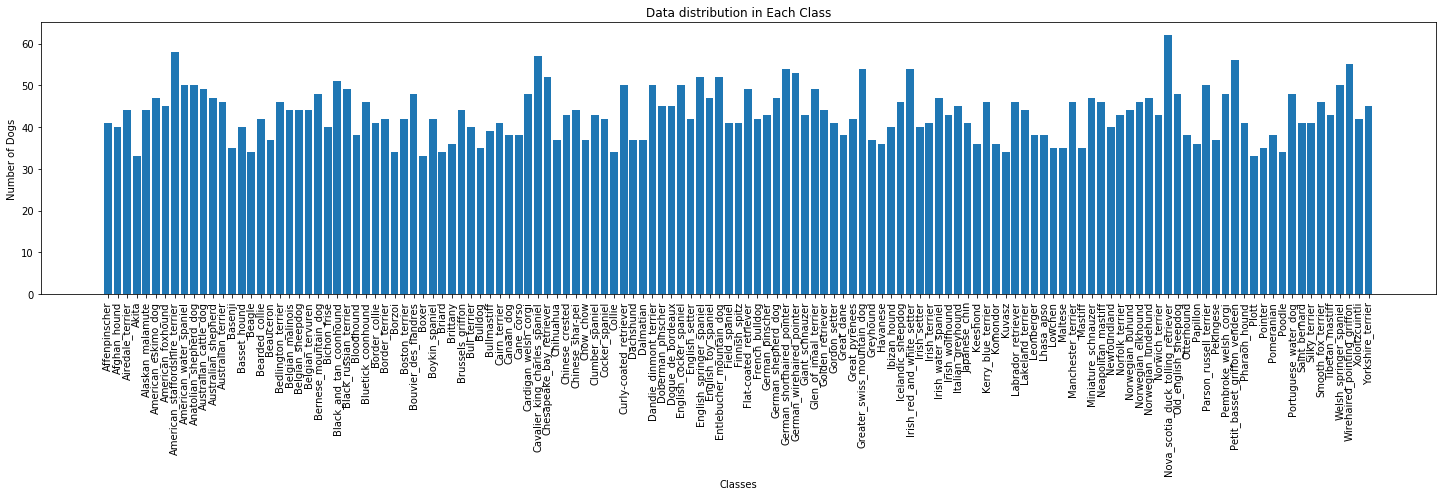

In [8]:
list_dogs=[]
num_dogs = []
for files in sorted(glob("/data/dog_images/train/*/")):
    list_dogs.append(files[27:-1])
    num_dogs.append(len(files))
    
    
plt.figure(figsize=(25,5))
plt.xticks(rotation=90)
plt.bar(list_dogs, num_dogs)
plt.title('Data distribution in Each Class')
plt.xlabel('Classes')
plt.ylabel('Number of Dogs')
    
plt.show()

In [9]:
n_dog_breed_classes = len(dog_names)

In [10]:
import os
from torchvision import datasets

### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

batch_size = 20
num_workers = 0

data_dir = '/data/dog_images/'

train_path = data_dir + 'train'
val_path = data_dir + 'valid'
test_path = data_dir + 'test'

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

train_dataset = datasets.ImageFolder(train_path,  transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),
            transforms.ToTensor(),
            normalize,
        ]))

val_dataset = datasets.ImageFolder(val_path,  transforms.Compose([
            transforms.Resize(size=(224,224)),
            transforms.ToTensor(),
            normalize,
        ]))

test_dataset = datasets.ImageFolder(test_path,  transforms.Compose([
             transforms.Resize(size=(224,224)),
            transforms.ToTensor(),
            normalize,
        ]))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size= batch_size, num_workers = num_workers, shuffle = True)

val_loader = torch.utils.data.DataLoader(val_dataset, batch_size= batch_size, num_workers = num_workers)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size= batch_size, num_workers = num_workers)

loaders_scratch = {
    'train': train_loader,
    'valid': val_loader,
    'test': test_loader
}

In [11]:
loaders_transfer = loaders_scratch.copy()

In [12]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)            
            loss.backward()
            optimizer.step()
            
            ## record the average training loss, using something like
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            
    # return trained model
    return model

In [13]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [26]:
import torchvision.models as models
import torch.nn as nn

## TODO: Specify model architecture 
model_transfer = models.densenet161(pretrained=True)

# Freeze training for all "features" layers
for param in model_transfer.features.parameters():
    param.requires_grad = False

n_inputs = model_transfer.classifier.in_features

# new layers automatically have requires_grad = True
last_layer = nn.Linear(n_inputs, n_dog_breed_classes)

model_transfer.classifier = last_layer

use_cuda = torch.cuda.is_available()
if use_cuda:
    model_transfer = model_transfer.cuda()

/opt/conda/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.torch/models/densenet161-8d451a50.pth
100%|██████████| 115730790/115730790 [00:02<00:00, 51180799.46it/s]


In [27]:
import torch.optim as optim
criterion_transfer = nn.CrossEntropyLoss()
# optimizer_transfer = optim.SGD(model_transfer.fc.parameters(), lr=0.02)
optimizer_transfer = optim.Adagrad(model_transfer.classifier.parameters(), lr=0.01)

In [24]:
# train the model
model_transfer = train(
    15, 
    loaders_transfer, 
    model_transfer, 
    optimizer_transfer, 
    criterion_transfer, 
    use_cuda, 
    'model_transfer.pt',
)

# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 2.545464 	Validation Loss: 1.081826
Validation loss decreased (inf --> 1.081826).  Saving model ...
Epoch: 2 	Training Loss: 1.316941 	Validation Loss: 0.777360
Validation loss decreased (1.081826 --> 0.777360).  Saving model ...
Epoch: 3 	Training Loss: 1.115513 	Validation Loss: 0.653974
Validation loss decreased (0.777360 --> 0.653974).  Saving model ...
Epoch: 4 	Training Loss: 1.007111 	Validation Loss: 0.595116
Validation loss decreased (0.653974 --> 0.595116).  Saving model ...
Epoch: 5 	Training Loss: 0.964999 	Validation Loss: 0.545928
Validation loss decreased (0.595116 --> 0.545928).  Saving model ...
Epoch: 6 	Training Loss: 0.909896 	Validation Loss: 0.505973
Validation loss decreased (0.545928 --> 0.505973).  Saving model ...
Epoch: 7 	Training Loss: 0.843353 	Validation Loss: 0.495662
Validation loss decreased (0.505973 --> 0.495662).  Saving model ...
Epoch: 8 	Training Loss: 0.844922 	Validation Loss: 0.489306
Validation loss decreased (0.49566

In [25]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.471578


Test Accuracy: 87% (735/836)


# Serving part

In [15]:
data_transfer = loaders_transfer
# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in data_transfer['train'].dataset.classes]

def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
    image = Image.open(img_path).convert('RGB')
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
    transformations = transforms.Compose([transforms.Resize(size=(224, 224)),
                                         transforms.ToTensor(),
                                         normalize])
    
    transformed_image = transformations(image)[:3,:,:].unsqueeze(0)
    
    if use_cuda:
        transformed_image = transformed_image.cuda()
    
    output = model_transfer(transformed_image)
    
    pred_index = torch.max(output,1)[1].item()
    
    return class_names[pred_index]

In [16]:
class_names

['Affenpinscher',
 'Afghan hound',
 'Airedale terrier',
 'Akita',
 'Alaskan malamute',
 'American eskimo dog',
 'American foxhound',
 'American staffordshire terrier',
 'American water spaniel',
 'Anatolian shepherd dog',
 'Australian cattle dog',
 'Australian shepherd',
 'Australian terrier',
 'Basenji',
 'Basset hound',
 'Beagle',
 'Bearded collie',
 'Beauceron',
 'Bedlington terrier',
 'Belgian malinois',
 'Belgian sheepdog',
 'Belgian tervuren',
 'Bernese mountain dog',
 'Bichon frise',
 'Black and tan coonhound',
 'Black russian terrier',
 'Bloodhound',
 'Bluetick coonhound',
 'Border collie',
 'Border terrier',
 'Borzoi',
 'Boston terrier',
 'Bouvier des flandres',
 'Boxer',
 'Boykin spaniel',
 'Briard',
 'Brittany',
 'Brussels griffon',
 'Bull terrier',
 'Bulldog',
 'Bullmastiff',
 'Cairn terrier',
 'Canaan dog',
 'Cane corso',
 'Cardigan welsh corgi',
 'Cavalier king charles spaniel',
 'Chesapeake bay retriever',
 'Chihuahua',
 'Chinese crested',
 'Chinese shar-pei',
 'Chow cho

In [28]:
model_transfer.load_state_dict(
    torch.load('model_transfer.pt', map_location=lambda storage, loc: storage)
)
model_transfer.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inpla

In [30]:
for dog_img in dog_test[:10]:
    print(predict_breed_transfer(dog_img))

Mastiff
Mastiff
Mastiff
Mastiff
Mastiff
Mastiff
Bullmastiff
Doberman pinscher
Black and tan coonhound
Doberman pinscher
